# Performance analysis

In [1]:
import numpy as np
import pathlib

import pathlib
import json
import numpy as np
import time
import seaborn as sns;
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import itertools
sns.set()


def bessel_correct(stddev):
    return stddev * np.sqrt(5./4.)

def confidence_interval_t(stddev):
    t_95 = 2.776
    return bessel_correct(stddev) * t_95
    

def flatten_metrics(metrics):
    flattened = {}
    task_metric_metric_name = [
        ("CoLA", "mcc", "Matthews correlation"),
        ("MNLI", "mnli_acc", "Accuracy"),
        ("MRPC", "acc", "Accuracy"),
        ("QNLI", "acc", "Accuracy"),
        ("QQP", "acc", "Accuracy"),
        ("RTE", "acc", "Accuracy"),
        ("SST-2", "acc", "Accuracy"),
        ("STS-B", "pearson", "Pearson correlation"),
        ("WNLI", "acc", "Accuracy")
    ]
    for task, metric, metric_name in task_metric_metric_name:
        flattened[task] = {
            "metric": metric_name,
            "mean": metrics[task][metric][0],
            "stdv": bessel_correct(metrics[task][metric][1]),
            "ci": confidence_interval_t(metrics[task][metric][1])
        }

    return flattened

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

def plot_all_task_metrics(metrics, save_path, bbox_to_anchor_left=0.8):
    all_tasks = sorted(metrics[0][1].keys())
    experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in metrics]
    experiment_names = [e_m[0] for e_m in experiment_metrics]

    metrics_data = [e_m[1] for e_m in experiment_metrics]
    x_pos = np.arange(len(experiment_names))
    
    fig, axs = plt.subplots(3, 3, figsize=(9,9))

    # Get a color map
    my_cmap = sns.color_palette("Paired")
    patterns = [ r"--" ,  r"||", r"\\" , r"\\||" , r"--", r"--||", r"//", r"//||", "*", "o", "|*", "/o"]

    for i, task in enumerate(all_tasks):
        means = [m[task]["mean"] for m in metrics_data]
        errors = [m[task]["stdv"] for m in metrics_data]
        print(task, errors)
        
        row = i // 3
        col = i % 3
        axs[row, col].bar(x_pos, means, yerr=errors, align='center', color=my_cmap)#my_cmap(my_norm(range(len(x_pos)))))   
        axs[row, col].set_ylabel(metrics_data[0][task]["metric"])
        axs[row, col].set_title(f"{task}")
        axs[row, col].set_xticks([])
        
        bars = axs[row, col].patches
        
        for bar, hatch in zip(bars, patterns):  # loop over bars and hatches to set hatches in correct order
            bar.set_hatch(hatch)
    legend_elements = [Patch(facecolor=my_cmap[i], hatch=patterns[i], label=exp) for i, exp in enumerate(experiment_names)]
    l_col = 3
    legend = plt.legend(flip(legend_elements, l_col), flip(experiment_names, l_col), loc='best', ncol=l_col, bbox_to_anchor=(bbox_to_anchor_left, -0.1), labelspacing=1.5, handlelength=4)
    for patch in legend.get_patches():
        patch.set_height(10)
        patch.set_y(-1)
    plt.subplots_adjust(right=1.5)
    fig.tight_layout()
    plt.show()
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

CoLA [0.0, 0.006143754412362066, 0.007477198196519187, 0.04352384763684086, 0.016234707970105507, 0.07668110862055756, 0.00320918531105945, 0.021440861854951]
MNLI [0.0, 0.0021193522422506394, 0.0030948525064219442, 0.04063610062519653, 0.01905089060983308, 0.03810539090562255, 0.007502075709982306, 0.02592029990757408]
MRPC [0.0, 0.00859592054742653, 0.01183090037857566, 0.0564098342169697, 0.16441676305145514, 0.1452813329560886, 0.16441676305145514, 0.02072491976138208]
QNLI [0.0, 0.0012455446338058877, 0.004495722184296906, 0.021950540691164196, 0.009712502411695498, 0.029776213103403944, 0.02030596932119511, 0.09302949468633943]
QQP [0.0, 0.0022292554224589093, 0.006089279275561371, 0.010635220785714869, 0.042754698137283526, 0.04506315132788595, 0.0, 0.1628786172538442]
RTE [0.0, 0.03099231195860618, 0.03490808593107169, 0.06172123943388755, 0.012865364390762071, 0.032631065815095096, 0.027087843295745966, 0.03610108303249098]
SST-2 [0.0, 0.0033825415604937627, 0.0056414559065361

/home/sai/miniconda3/envs/bertexp/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


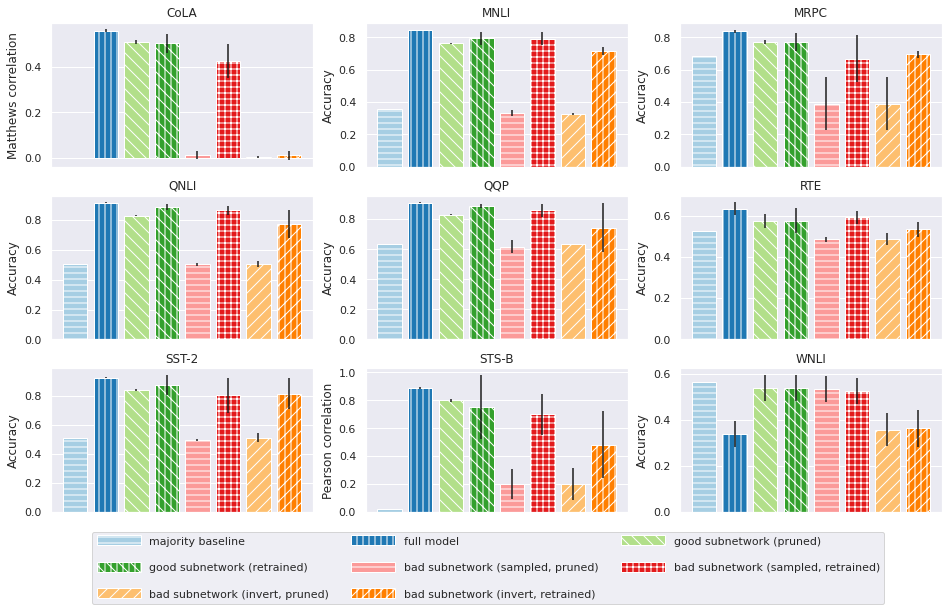

In [2]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {
   
    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    "full model": evaluation_dir / "no_mask" / "baseline" / "results.json",

    "good subnetwork (pruned)": evaluation_dir / "head_mlp" / "baseline" / "results.json",
    "good subnetwork (retrained)": evaluation_dir / "head_mlp_retrained" / "baseline" / "results.json",

    "bad subnetwork (sampled, pruned)": evaluation_dir / "head_mlp_bad" / "baseline" / "results.json",
    "bad subnetwork (sampled, retrained)": evaluation_dir / "head_mlp_bad_retrained" / "baseline" / "results.json",


    "bad subnetwork (invert, pruned)": evaluation_dir / "head_mlp_invert" / "baseline" / "results.json",
    "bad subnetwork (invert, retrained)": evaluation_dir / "head_mlp_invert_retrained" / "baseline" / "results.json",

}


analyzed_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    analyzed_metrics.append((name, metrics))
plot_all_task_metrics(analyzed_metrics, "evaluation/importance_pruning_evaluation.pdf")

CoLA [0.0, 0.006143754412362066, 0.05983303812067071, 0.018297490054378477, 0.011166400883980184, 0.03357079721884241, 0.051761834632323346, 0.14859026287503627]
MNLI [0.0, 0.0021193522422506394, 0.014347762967675998, 0.0030692552891272706, 4.5564299083022196e-05, 0.0032539418079819394, 0.005811457975088601, 0.01427650267640253]
MRPC [0.0, 0.00859592054742653, 0.16441676305145514, 0.0040273717463615005, 0.16441676305145514, 0.007229353531251263, 0.16441676305145514, 0.008202549279745844]
QNLI [0.0, 0.0012455446338058877, 0.03493937036138562, 0.003433339239257723, 0.015648653803891407, 0.027463968959784757, 0.007052043996287497, 0.07762950153216888]
QQP [0.0, 0.0022292554224589093, 0.00015486001328217795, 0.0014853444731962914, 0.07136834326405463, 0.0005710312332730845, 0.0, 0.04054587096081235]
RTE [0.0, 0.03099231195860618, 0.024670540885588302, 0.033537109494566335, 0.024217342716604244, 0.032830158972966546, 6.206335383118183e-17, 0.028494710845734468]
SST-2 [0.0, 0.003382541560493

/home/sai/miniconda3/envs/bertexp/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


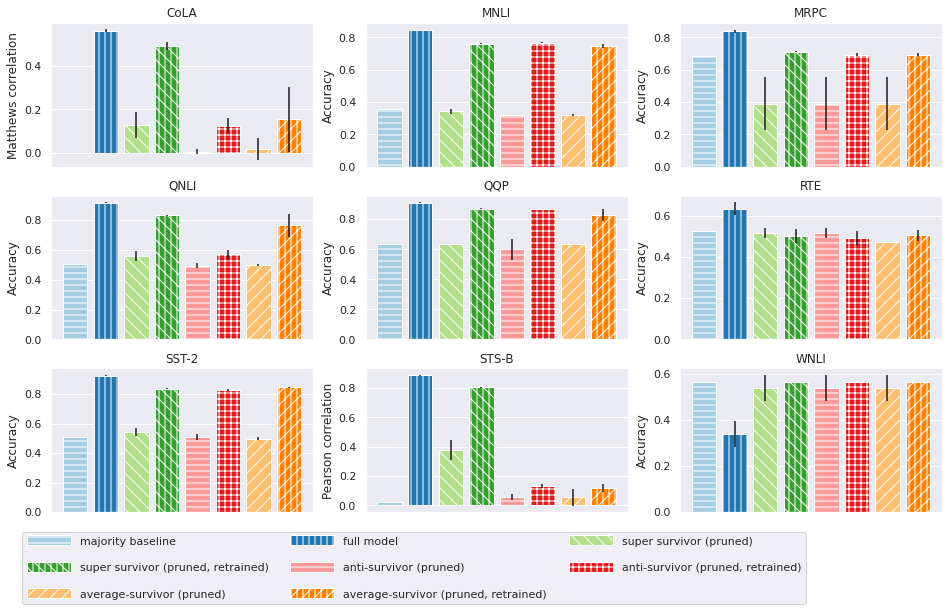

In [6]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {
   
    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    #"1 head mlp baseline  (retrained)": evaluation_dir / "head_mlp_zero_retrained" / "baseline" / "results.json",
    "full model": evaluation_dir / "no_mask" / "baseline" / "results.json",

    
    "super survivor (pruned)": evaluation_dir / "head_mlp_super" / "baseline" / "results.json",
    "super survivor (pruned, retrained)": evaluation_dir / "head_mlp_super_retrained" / "baseline" / "results.json",
    "anti-survivor (pruned)": evaluation_dir / "head_mlp_super_bizzaro" / "baseline" / "results.json",
    "anti-survivor (pruned, retrained)": evaluation_dir / "head_mlp_super_bizzaro_retrained" / "baseline" / "results.json",
    "average-survivor (pruned)": evaluation_dir / "head_mlp_super_midling" / "baseline" / "results.json",
    "average-survivor (pruned, retrained)": evaluation_dir / "head_mlp_super_midling_retrained" / "baseline" / "results.json",
    
#     "anti-survivor 2  (pruned)": evaluation_dir / "head_mlp_super_bizzaro_2" / "baseline" / "results.json",
#     "anti-survivor 2  (retrained)": evaluation_dir / "head_mlp_super_bizzaro_2_retrained" / "baseline" / "results.json",

#     "anti-survivor old (pruned)": evaluation_dir / "head_mlp_super_bad" / "baseline" / "results.json",
#     "anti-survivor old (retrained)": evaluation_dir / "head_mlp_super_bad_retrained" / "baseline" / "results.json",

}

analyzed_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    analyzed_metrics.append((name, metrics))
plot_all_task_metrics(analyzed_metrics,  "evaluation/importance_pruning_super_evaluation.pdf", 0.5)

CoLA [0.0, 0.006143754412362066, 0.007749116937139847, 0.015049113374024635, 0.028108885818466958, 0.061666909478363986, 0.0, 0.032624667014074994]
MNLI [0.0, 0.0021193522422506394, 0.0036390160731843615, 0.0010325115484591616, 0.013056696166569098, 0.003756361273570715, 0.0, 0.0025420224044573904]
MRPC [0.0, 0.00859592054742653, 0.020017173518720996, 0.009865005783087313, 0.16441676305145514, 0.014291548761875742, 0.16441676305145514, 0.008419394135940061]
QNLI [0.0, 0.0012455446338058877, 0.008421276672449896, 0.003785632266324032, 0.01786474132222184, 0.008516824322808928, 0.022451987515672713, 0.0006650522469187001]
QQP [0.0, 0.0022292554224589093, 0.005524500276008748, 0.002130754069743664, 0.0, 0.0028128129984700432, 0.0, 0.0010713895299331393]
RTE [0.0, 0.03099231195860618, 0.01475293627559752, 0.01662218690717881, 0.003228979028880559, 0.018158521790554952, 0.0296600662908935, 0.0296600662908935]
SST-2 [0.0, 0.0033825415604937627, 0.007777901356795035, 0.004543947879852987, 0.0

/home/sai/miniconda3/envs/bertexp/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


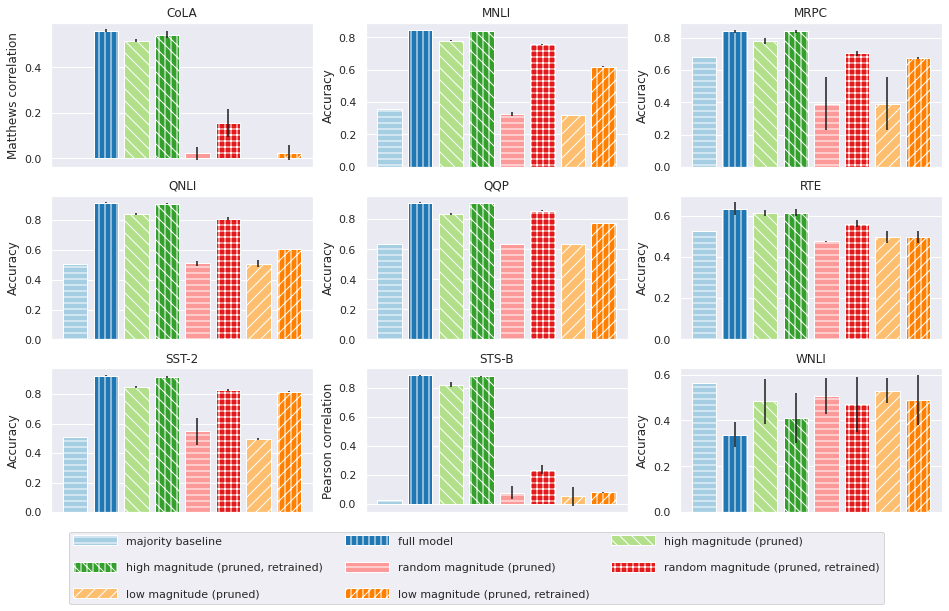

In [7]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {

    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    "full model": evaluation_dir / "no_mask" / "baseline" / "results.json",
    "high magnitude (pruned)": evaluation_dir / "global_magnitude" / "baseline" / "results.json",
    "high magnitude (pruned, retrained)": evaluation_dir / "global_magnitude_retrained" / "baseline" / "results.json",
    "random magnitude (pruned)": evaluation_dir / "global_random" / "baseline" / "results.json",
    "random magnitude (pruned, retrained)": evaluation_dir / "global_random_retrained" / "baseline" / "results.json",
    "low magnitude (pruned)": evaluation_dir / "global_bad" / "baseline" / "results.json",
    "low magnitude (pruned, retrained)": evaluation_dir / "global_bad_retrained" / "baseline" / "results.json",
#     "bad-mimic-pruned, retrained": evaluation_dir / "global_bad_mask_mimic_size" / "baseline" / "results.json",

#     "bad-mimic-pruned, retrained": evaluation_dir / "global_bad_mask_mimic_size_retrained" / "baseline" / "results.json",
#     "m-pruned mimic": evaluation_dir / "global_magnitude_mask_mimic_size" / "baseline" / "results.json",
#     "m-pruned mimic, retrained": evaluation_dir / "global_magnitude_mask_mimic_size_retrained" / "baseline" / "results.json",

#     "r-pruned, mimic": evaluation_dir / "global_random_mask_mimic_size" / "baseline" / "results.json",
#     "r-pruned mimic, retrained": evaluation_dir / "global_random_mask_mimic_size_retrained" / "baseline" / "results.json",
}


m_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    m_metrics.append((name, metrics))
plot_all_task_metrics(m_metrics, "evaluation/magnitude_pruning_evaluation.pdf")

In [8]:


def print_table(analyzed_metrics, horizontal_tasks=True):
    experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in analyzed_metrics]

    if horizontal_tasks:
        tasks =  sorted(experiment_metrics[0][1].keys())
        tasks_metrics = [f"{task} {experiment_metrics[0][1][task]['metric']}" for task in tasks]
        table_md = f"|Experiment|{'|'.join(tasks)}|\n"
        table_md += f"|---|---|{'---|' * len(tasks)}\n"
        for experiment, metrics in experiment_metrics:

            mean_stds = [ f"{metrics[task]['mean']:.2f} *** {metrics[task]['stdv']:.2f}" for  task in tasks]
            table_md += f"|{experiment}|{'|'.join(mean_stds)}|\n"
        print(table_md)
    else:
        experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in analyzed_metrics]
        table_md = ""
        experiments = [em[0] for em in experiment_metrics]
        table_md += f"|Task|Metric|{'|'.join(experiments)}|\n"
        table_md += f"|---|---|{'---|' * len(experiments)}\n"
        tasks =  sorted(experiment_metrics[0][1].keys())
        for task in tasks:
            mean_stds = [ f"{metrics[task]['mean']:.2f} ± {metrics[task]['stdv']:.2f}" for _, metrics in experiment_metrics]
            table_md += f"|{task}|{experiment_metrics[0][1][task]['metric']}|{'|'.join(mean_stds)}|\n"
        print(table_md)

In [9]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {
   
    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    "full model": evaluation_dir / "no_mask" / "baseline" / "results.json",
    "good subnetwork (pruned)": evaluation_dir / "head_mlp" / "baseline" / "results.json",
    "good subnetwork (retrained)": evaluation_dir / "head_mlp_retrained" / "baseline" / "results.json",
    "bad subnetwork (sampled, pruned)": evaluation_dir / "head_mlp_bad" / "baseline" / "results.json",
    "bad subnetwork (sampled, retrained)": evaluation_dir / "head_mlp_bad_retrained" / "baseline" / "results.json",
    "bad subnetwork (invert, pruned)": evaluation_dir / "head_mlp_invert" / "baseline" / "results.json",
    "bad subnetwork (invert, retrained)": evaluation_dir / "head_mlp_invert_retrained" / "baseline" / "results.json",
    
    "super survivor (pruned)": evaluation_dir / "head_mlp_super" / "baseline" / "results.json",
    "super survivor (pruned, retrained)": evaluation_dir / "head_mlp_super_retrained" / "baseline" / "results.json",
    "anti-survivor (pruned)": evaluation_dir / "head_mlp_super_bizzaro" / "baseline" / "results.json",
    "anti-survivor (pruned, retrained)": evaluation_dir / "head_mlp_super_bizzaro_retrained" / "baseline" / "results.json",
    "average-survivor (pruned)": evaluation_dir / "head_mlp_super_midling" / "baseline" / "results.json",
    "average-survivor (pruned, retrained)": evaluation_dir / "head_mlp_super_midling_retrained" / "baseline" / "results.json",
    
    "high magnitude (pruned)": evaluation_dir / "global_magnitude" / "baseline" / "results.json",
    "high magnitude (pruned, retrained)": evaluation_dir / "global_magnitude_retrained" / "baseline" / "results.json",
    "random magnitude (pruned)": evaluation_dir / "global_random" / "baseline" / "results.json",
    "random magnitude (pruned, retrained)": evaluation_dir / "global_random_retrained" / "baseline" / "results.json",
    "low magnitude (pruned)": evaluation_dir / "global_bad" / "baseline" / "results.json",
    "low magnitude (pruned, retrained)": evaluation_dir / "global_bad_retrained" / "baseline" / "results.json",
}


analyzed_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    analyzed_metrics.append((name, metrics))
print_table(analyzed_metrics)

|Experiment|CoLA|MNLI|MRPC|QNLI|QQP|RTE|SST-2|STS-B|WNLI|
|---|---|---|---|---|---|---|---|---|---|---|
|majority baseline|0.00 *** 0.00|0.35 *** 0.00|0.68 *** 0.00|0.51 *** 0.00|0.63 *** 0.00|0.53 *** 0.00|0.51 *** 0.00|0.02 *** 0.00|0.56 *** 0.00|
|full model|0.56 *** 0.01|0.84 *** 0.00|0.84 *** 0.01|0.92 *** 0.00|0.91 *** 0.00|0.63 *** 0.03|0.93 *** 0.00|0.89 *** 0.00|0.34 *** 0.06|
|good subnetwork (pruned)|0.51 *** 0.01|0.76 *** 0.00|0.77 *** 0.01|0.83 *** 0.00|0.83 *** 0.01|0.57 *** 0.03|0.84 *** 0.01|0.80 *** 0.01|0.54 *** 0.06|
|good subnetwork (retrained)|0.50 *** 0.04|0.80 *** 0.04|0.77 *** 0.06|0.89 *** 0.02|0.89 *** 0.01|0.58 *** 0.06|0.87 *** 0.07|0.75 *** 0.23|0.54 *** 0.06|
|bad subnetwork (sampled, pruned)|0.01 *** 0.02|0.33 *** 0.02|0.39 *** 0.16|0.50 *** 0.01|0.62 *** 0.04|0.48 *** 0.01|0.50 *** 0.01|0.20 *** 0.11|0.54 *** 0.06|
|bad subnetwork (sampled, retrained)|0.43 *** 0.08|0.79 *** 0.04|0.67 *** 0.15|0.86 *** 0.03|0.86 *** 0.05|0.59 *** 0.03|0.81 *** 0.12|0.70 *